First I need to import all the necessary libraries:

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup # this module helps in web scrapping.
import requests  # this module helps us to download a web page

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import re # module for managing regex
import folium # map rendering library
from sklearn.cluster import KMeans # import k-means from clustering stage

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib.pyplot as plt

The first part of the project will be creating a dataframe with all the neighborhoods of London. I will use the data from the Wikipedia page - https://en.wikipedia.org/wiki/List_of_areas_of_London. 

In [2]:
# Creating the dataframe I will be working with:

column_names = ['Neighborhood', 'Borough', 'Post_town'] 

london_nh = pd.DataFrame(columns=column_names)

#the data I need about London neighborhoods is available on Wikipedia

url = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'

# getting the contents of the webpage in text format and store in a variable called data
data  = requests.get(url).text

soup = BeautifulSoup(data,"html5lib")

Next, using the BeautifulSoup library I find the table, get the data I need and transform it into the dataframe.

In [3]:
#find a html table in the web page
table = soup.find_all('table')[1]

#Get the cells from the 3 first columns in the table
for row in table.find_all('tr'):
    col = row.find_all("td")
  # Get data from the 3 first columns in each row.
    if col:
        neighborhood=col[0].text
        borough=col[1].text
        post_town=col[2].text
        london_nh = london_nh.append({"Neighborhood":neighborhood, "Borough":borough, "Post_town":post_town}, ignore_index=True) # adding the data to our df
    
london_nh

,Neighborhood,Borough,Post_town
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON
2,Addington,Croydon[8],CROYDON
3,Addiscombe,Croydon[8],CROYDON
4,Albany Park,Bexley,"BEXLEY, SIDCUP"
...,...,...,...
526,Woolwich,Greenwich,LONDON
527,Worcester Park,"Sutton, Kingston upon Thames",WORCESTER PARK
528,Wormwood Scrubs,Hammersmith and Fulham,LONDON
529,Yeading,Hillingdon,HAYES


I want to work only with neighborhoods which post town is London, so I filter the data:

In [4]:
london1 = london_nh[london_nh.Post_town == "LONDON"].reset_index(drop=True)
london1

,Neighborhood,Borough,Post_town
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON
2,Aldgate,City[10],LONDON
3,Aldwych,Westminster[10],LONDON
4,Anerley,Bromley[11],LONDON
...,...,...,...
292,Wood Green,Haringey,LONDON
293,Woodford,Redbridge,LONDON
294,Woodside Park,Barnet,LONDON
295,Woolwich,Greenwich,LONDON


I see that in the "Borough" columns I have unnecesary numbers and brackets, so I need to get rid of them. To do so I will use the regular expressions.

In [5]:
for row in london1.index:
    london1['Borough'][row]=re.sub(r' ?\[[0-9]+\]', '', london1['Borough'][row])

london1

,Neighborhood,Borough,Post_town
0,Abbey Wood,"Bexley, Greenwich",LONDON
1,Acton,"Ealing, Hammersmith and Fulham",LONDON
2,Aldgate,City,LONDON
3,Aldwych,Westminster,LONDON
4,Anerley,Bromley,LONDON
...,...,...,...
292,Wood Green,Haringey,LONDON
293,Woodford,Redbridge,LONDON
294,Woodside Park,Barnet,LONDON
295,Woolwich,Greenwich,LONDON


297 neighborhoods is a lot, so I decide to work only with the "Inner London" boroughs, which are:
Camden,
Greenwich,
Hackney,
Hammersmith and Fulham,
Islington,
Kensington and Chelsea,
Lambeth,
Lewisham,
Southwark,
Tower Hamlets,
Wandsworth,
Westminster.

In [6]:
#creating a list with "Inner London" boroughs:
inner_london_list=[
    'Camden', 
    'Greenwich', 
    'Hackney', 
    'Hammersmith and Fulham', 
    'Islington', 
    'Kensington and Chelsea', 
    'Lambeth', 
    'Lewisham', 
    'Southwark', 
    'Tower Hamlets', 
    'Wandsworth', 
    'Westminster']

#creating a new dataframe with the same column names
inner_london= pd.DataFrame(columns=column_names)

for row in london1.index:
    if london1['Borough'][row] in inner_london_list:
        inner_london = inner_london.append({
            "Neighborhood":london1['Neighborhood'][row], 
            "Borough":london1['Borough'][row], 
            "Post_town":london1['Post_town'][row]}, 
            ignore_index=True) # adding the data to the new df
        
inner_london

,Neighborhood,Borough,Post_town
0,Aldwych,Westminster,LONDON
1,Angel,Islington,LONDON
2,Archway,Islington,LONDON
3,Balham,Wandsworth,LONDON
4,Bankside,Southwark,LONDON
...,...,...,...
163,Westminster,Westminster,LONDON
164,White City,Hammersmith and Fulham,LONDON
165,Whitechapel,Tower Hamlets,LONDON
166,Woolwich,Greenwich,LONDON


Apart from the list of neighboorhoods in Inner London I also need their coordinates (latitude and longitude). For that I will use the geopy library.

In [7]:
geolocator = Nominatim(user_agent="london_explorer")
inner_london['Latitude']=""
inner_london['Longitude']=""

for row in inner_london.index:
    address = (inner_london['Neighborhood'][row], inner_london['Borough'][row], inner_london['Post_town'][row])
    location = geolocator.geocode(address)
    if location:
        inner_london['Latitude'][row] = location.latitude
        inner_london['Longitude'][row] = location.longitude
    else:
        inner_london['Latitude'][row] = "Not recognized"
        inner_london['Longitude'][row] = "Not recognized"
        
inner_london

,Neighborhood,Borough,Post_town,Latitude,Longitude
0,Aldwych,Westminster,LONDON,51.513103,-0.11492
1,Angel,Islington,LONDON,51.531842,-0.105714
2,Archway,Islington,LONDON,51.565437,-0.134998
3,Balham,Wandsworth,LONDON,51.444749,-0.151294
4,Bankside,Southwark,LONDON,51.507499,-0.099302
...,...,...,...,...,...
163,Westminster,Westminster,LONDON,51.500444,-0.12654
164,White City,Hammersmith and Fulham,LONDON,51.511935,-0.224236
165,Whitechapel,Tower Hamlets,LONDON,51.518623,-0.062081
166,Woolwich,Greenwich,LONDON,51.49366,0.053307


Now I need to check if all the neighborhoods were assigned coordinates and if not, then delete these neighborhoods from my analisys.

In [8]:
inner_london = inner_london[inner_london.Latitude != "Not recognized"].reset_index(drop=True)
inner_london = inner_london[inner_london.Longitude != "Not recognized"].reset_index(drop=True)

In [9]:
#checking the size of the dataframe after above operation
inner_london.shape

(164, 5)

In [10]:
#checking the type of data in each columns (I need coordinates to be floats)
inner_london.dtypes

Neighborhood    object
Borough         object
Post_town       object
Latitude        object
Longitude       object
dtype: object

In [11]:
#I need both Latitude and Longitude to be floats, so I convert them
inner_london['Latitude'] = pd.to_numeric(inner_london['Latitude'],errors = 'raise')
inner_london['Longitude'] = pd.to_numeric(inner_london['Longitude'],errors = 'raise')

In [12]:
#checking the data types again
inner_london.dtypes

Neighborhood     object
Borough          object
Post_town        object
Latitude        float64
Longitude       float64
dtype: object

Let's look how the selected London neighborhoods look at the map.

In [13]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[51.5074, -0.1278], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(inner_london['Latitude'], inner_london['Longitude'], inner_london['Borough'], inner_london['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

Now I'm gonna use Foursquare API, so I need to define Foursquare Credentials and Version:

In [14]:
CLIENT_ID = 'Y3R0ZBTHYBHXW2RLSPNHMLQ34GFOW4LXAVPJTJCUKRRK2HGL' # my Foursquare ID
CLIENT_SECRET = 'KS33CXQB2TVIUKB4NNLKASJLSZXOS25D4DVUOK0RKMV3Y4MF' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Below I define a function that explores the nearby venues of each neighborhood and add it to the dataframe nearby_venues.

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now I use this function to find nearby venues of the London boroughs chosen in the previous step.

In [16]:
london_venues = getNearbyVenues(names=inner_london['Neighborhood'],
                                   latitudes=inner_london['Latitude'],
                                   longitudes=inner_london['Longitude']
                                  )

Aldwych
Angel
Archway
Balham
Bankside
Barnsbury
Battersea
Bayswater
Belgravia
Bellingham
Belsize Park
Bermondsey
Bethnal Green
Blackheath
Blackheath Royal Standard
Blackwall
Bloomsbury
Bow
Brixton
Brockley
Camberwell
Cambridge Heath
Camden Town
Canary Wharf
Canonbury
Catford
Chalk Farm
Charing Cross
Charlton
Chelsea
Chinatown
Chinbrook
Clerkenwell
Covent Garden
Crofton Park
Cubitt Town
Dalston
Denmark Hill
Deptford
Dulwich
Earls Court
Earlsfield
East Dulwich
Elephant and Castle
Eltham
Finsbury
Fitzrovia
Forest Hill
Frognal
Fulham
Gipsy Hill
Gospel Oak
Greenwich
Grove Park
Hackney
Hackney Central
Hackney Marshes
Hackney Wick
Haggerston
Hammersmith
Hampstead
Herne Hill
Highbury
Highgate
Hither Green
Holborn
Holland Park
Holloway
Homerton
Honor Oak
Hoxton
Isle of Dogs
Islington
Kensington
Kentish Town
Kidbrooke
Knightsbridge
Ladywell
Lambeth
Lea Bridge
Leamouth
Lee
Lewisham
Limehouse
Lisson Grove
Little Venice
Lower Clapton
Maida Vale
Manor House
Mayfair
Maze Hill
Middle Park
Mile End
Mil

Let's check how many unique venue categories were found:

In [17]:
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))

There are 366 uniques categories.


In [18]:
london_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aldwych,51.513103,-0.11492,180 The Strand,51.512671,-0.115009,Art Gallery
1,Aldwych,51.513103,-0.11492,The Delaunay,51.513181,-0.117988,Restaurant
2,Aldwych,51.513103,-0.11492,Twinings,51.513421,-0.112955,Tea Room
3,Aldwych,51.513103,-0.11492,The Pig and Goose,51.513287,-0.113273,French Restaurant
4,Aldwych,51.513103,-0.11492,Temple Brew House,51.512940,-0.113029,Pub


In [19]:
london_venues.shape

(6722, 7)

I am interested only in restaurants, so I am filtering the results accordingly:

In [20]:
london_venues=london_venues[london_venues['Venue Category'].str.contains("Restaurant")]
london_venues.shape

(1422, 7)

In [41]:
london_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Aldwych,51.513103,-0.11492,The Delaunay,51.513181,-0.117988,Restaurant
3,Aldwych,51.513103,-0.11492,The Pig and Goose,51.513287,-0.113273,French Restaurant
9,Aldwych,51.513103,-0.11492,Roka,51.513312,-0.116194,Japanese Restaurant
24,Aldwych,51.513103,-0.11492,Gaucho,51.514069,-0.111131,Argentinian Restaurant
32,Aldwych,51.513103,-0.11492,Spring,51.510966,-0.118575,Restaurant


In [43]:
print('There are {} unique restaurant categories.'.format(len(london_venues['Venue Category'].unique())))

There are 78 unique restaurant categories.


In [22]:
print('They are located in {} neighborhoods.'.format(len(london_venues['Neighborhood'].unique())))

They are located in 152 neighborhoods.


Now I am analyzing the output by using one hot encoding and then grouping the results by neighborhood and by the mean of the frequency of occurrence of each category:

In [23]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Neighborhood'] = london_venues['Neighborhood']

# move neighborhood column to the first column
cols = list(london_onehot.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index('Neighborhood')) #removing "Neighborhood" from the list
london_onehot = london_onehot[['Neighborhood']+cols]

london_onehot

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,...,Szechuan Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Veneto Restaurant,Vietnamese Restaurant,Xinjiang Restaurant,Yoshoku Restaurant
1,Aldwych,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Aldwych,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Aldwych,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,Aldwych,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32,Aldwych,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6691,Whitechapel,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6704,Whitechapel,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6705,Whitechapel,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6706,Whitechapel,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
#grouping the results
london_grouped = london_onehot.groupby('Neighborhood').mean().reset_index()
london_grouped

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,...,Szechuan Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Veneto Restaurant,Vietnamese Restaurant,Xinjiang Restaurant,Yoshoku Restaurant
0,Aldwych,0.000000,0.0,0.071429,0.0,0.071429,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.071429,0.0,0.000000,0.0,0.000000,0.0,0.0
1,Angel,0.052632,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.052632,0.0,...,0.0,0.000000,0.000000,0.052632,0.0,0.000000,0.0,0.105263,0.0,0.0
2,Archway,0.000000,0.0,0.000000,0.0,0.000000,0.142857,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.142857,0.0,0.000000,0.0,0.0
3,Balham,0.000000,0.0,0.000000,0.0,0.000000,0.090909,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
4,Bankside,0.000000,0.0,0.000000,0.0,0.000000,0.052632,0.052632,0.000000,0.0,...,0.0,0.052632,0.052632,0.000000,0.0,0.000000,0.0,0.052632,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,West Norwood,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
148,Westcombe Park,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
149,Westminster,0.000000,0.0,0.000000,0.0,0.000000,0.200000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
150,White City,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0


From exploring the data and previoues analysis I know that amoung restaurant categories there is one called "Restaurant". As I am analyzing only restaurants, this category is non-informative for me, so I will drop it:

In [25]:
london_grouped.drop(['Restaurant'], axis=1, inplace=True)

#checking how many categories there are now
len(london_grouped.columns)-1

77

Now I will write a function to sort the restaurants in descending order.

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Next I create the new dataframe and display the top 10 most common types of restaurants for each neighborhood.

In [80]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = london_grouped['Neighborhood']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,Aldwych,Japanese Restaurant,French Restaurant,American Restaurant,Lebanese Restaurant,Argentinian Restaurant,Korean Restaurant,Turkish Restaurant,Italian Restaurant,North Indian Restaurant,Peruvian Restaurant
1,Angel,Mediterranean Restaurant,Vietnamese Restaurant,Indian Restaurant,French Restaurant,Caucasian Restaurant,Mexican Restaurant,Korean Restaurant,Japanese Restaurant,Hunan Restaurant,Sushi Restaurant
2,Archway,Italian Restaurant,Indian Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Kebab Restaurant,Japanese Restaurant,Persian Restaurant,Pakistani Restaurant,Paella Restaurant,Okonomiyaki Restaurant
3,Balham,Italian Restaurant,Indian Restaurant,Moroccan Restaurant,Asian Restaurant,Japanese Restaurant,Portuguese Restaurant,North Indian Restaurant,Peruvian Restaurant,Persian Restaurant,Pakistani Restaurant
4,Bankside,Italian Restaurant,Portuguese Restaurant,Israeli Restaurant,Vietnamese Restaurant,Ramen Restaurant,Asian Restaurant,Australian Restaurant,Modern European Restaurant,Indian Restaurant,Spanish Restaurant
...,...,...,...,...,...,...,...,...,...,...,...
147,West Norwood,Italian Restaurant,Afghan Restaurant,Moroccan Restaurant,Peruvian Restaurant,Persian Restaurant,Pakistani Restaurant,Paella Restaurant,Okonomiyaki Restaurant,North Indian Restaurant,New American Restaurant
148,Westcombe Park,Japanese Restaurant,Doner Restaurant,Afghan Restaurant,North Indian Restaurant,Polish Restaurant,Peruvian Restaurant,Persian Restaurant,Pakistani Restaurant,Paella Restaurant,Okonomiyaki Restaurant
149,Westminster,Sushi Restaurant,Asian Restaurant,Italian Restaurant,Indian Restaurant,Afghan Restaurant,Peruvian Restaurant,Persian Restaurant,Pakistani Restaurant,Paella Restaurant,Okonomiyaki Restaurant
150,White City,New American Restaurant,Japanese Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Fast Food Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Middle Eastern Restaurant,Moroccan Restaurant


Now I'm ready to start K-means clustering. First I need to decide how many clusters I should create. For that I use the "elbow method".

C:\Users\magda\miniconda3\envs\coursera_ibm\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


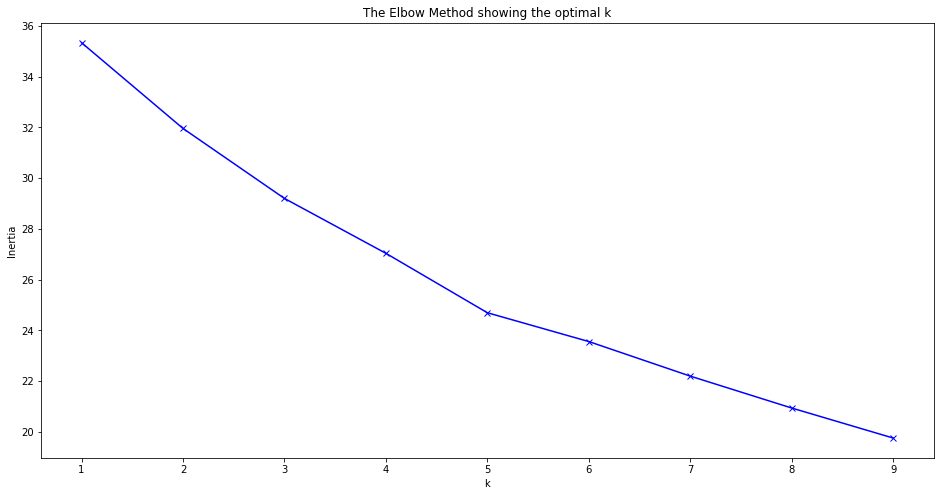

In [59]:
london_grouped_clustering = london_grouped.drop('Neighborhood', 1)

inertia = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(london_grouped_clustering)
    inertia.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()
    

Basing on the above graph I'm gonna run k-means to cluster the neighborhood into 5 clusters.

In [79]:
# set number of clusters
kclusters = 5

london_grouped_clustering = london_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 4, 0, 0, 0, 0, 0, 4])

Next I create a new dataframe that includes the cluster as well as the top 10 restaurants for each neighborhood. I take into account only the  152 neighborhoods where restaurants are located.

In [81]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)

london_merged = inner_london

# merge london_grouped with london_bor to add latitude/longitude for each neighborhood
london_merged = london_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how='inner')

london_merged.head()

,Neighborhood,Borough,Post_town,Latitude,Longitude,Cluster_Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,Aldwych,Westminster,LONDON,51.513103,-0.114920,0,Japanese Restaurant,French Restaurant,American Restaurant,Lebanese Restaurant,Argentinian Restaurant,Korean Restaurant,Turkish Restaurant,Italian Restaurant,North Indian Restaurant,Peruvian Restaurant
1,Angel,Islington,LONDON,51.531842,-0.105714,0,Mediterranean Restaurant,Vietnamese Restaurant,Indian Restaurant,French Restaurant,Caucasian Restaurant,Mexican Restaurant,Korean Restaurant,Japanese Restaurant,Hunan Restaurant,Sushi Restaurant
2,Archway,Islington,LONDON,51.565437,-0.134998,0,Italian Restaurant,Indian Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Kebab Restaurant,Japanese Restaurant,Persian Restaurant,Pakistani Restaurant,Paella Restaurant,Okonomiyaki Restaurant
3,Balham,Wandsworth,LONDON,51.444749,-0.151294,4,Italian Restaurant,Indian Restaurant,Moroccan Restaurant,Asian Restaurant,Japanese Restaurant,Portuguese Restaurant,North Indian Restaurant,Peruvian Restaurant,Persian Restaurant,Pakistani Restaurant
4,Bankside,Southwark,LONDON,51.507499,-0.099302,0,Italian Restaurant,Portuguese Restaurant,Israeli Restaurant,Vietnamese Restaurant,Ramen Restaurant,Asian Restaurant,Australian Restaurant,Modern European Restaurant,Indian Restaurant,Spanish Restaurant


Now I visualize the created clusters:

In [88]:
# create map
london_clusters = folium.Map(location=[51.5074, -0.1278], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Neighborhood'], london_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(london_clusters)
       
london_clusters

Next step is analyzing the clusters. Firstly let's see how many neighborhoods are included in each cluster.

In [82]:
london_merged.groupby(['Cluster_Labels']).count()

,Neighborhood,Borough,Post_town,Latitude,Longitude,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
Cluster_Labels,,,,,,,,,,,,,,,
0,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108
1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
3,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
4,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24


In order to analyze the clusters I am adding the data about clusters (to which cluster is each neighborhood assigned) to the dataframe with grouped one-hot encoding. I am dropping all unnecessary columns - I need only Neighborhoods, Cluster Label and restaurant categories. Next I am grouping the results by clusters.

In [50]:
#creating a df with restaurant data (frequency) and cluster info

cluster_rest = london_merged
cluster_rest = cluster_rest.join(london_grouped.set_index('Neighborhood'), on='Neighborhood', how='inner')

#dropping all unnecessary columns - I need only Neighborhoods, Cluster Label and restaurant categories
cluster_rest.drop(['Borough', 'Post_town', 'Latitude', 'Longitude', '1st Most Common Restaurant', '2nd Most Common Restaurant', '3rd Most Common Restaurant', '4th Most Common Restaurant', '5th Most Common Restaurant', '6th Most Common Restaurant', '7th Most Common Restaurant', '8th Most Common Restaurant', '9th Most Common Restaurant', '10th Most Common Restaurant'], axis=1, inplace=True)

cluster_rest

,Neighborhood,Cluster_Labels,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,...,Szechuan Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Veneto Restaurant,Vietnamese Restaurant,Xinjiang Restaurant,Yoshoku Restaurant
0,Aldwych,0,0.000000,0.0,0.071429,0.0,0.071429,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.071429,0.0,0.000000,0.0,0.000000,0.0,0.0
1,Angel,0,0.052632,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.052632,...,0.0,0.000000,0.000000,0.052632,0.0,0.000000,0.0,0.105263,0.0,0.0
2,Archway,0,0.000000,0.0,0.000000,0.0,0.000000,0.142857,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.142857,0.0,0.000000,0.0,0.0
3,Balham,4,0.000000,0.0,0.000000,0.0,0.000000,0.090909,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
4,Bankside,0,0.000000,0.0,0.000000,0.0,0.000000,0.052632,0.052632,0.000000,...,0.0,0.052632,0.052632,0.000000,0.0,0.000000,0.0,0.052632,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,West Norwood,3,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
158,Westcombe Park,0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
159,Westminster,0,0.000000,0.0,0.000000,0.0,0.000000,0.200000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
160,White City,0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0


In [51]:
#grouping the results
cluster_grouped = cluster_rest.groupby('Cluster_Labels').mean().reset_index()
cluster_grouped

,Cluster_Labels,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,...,Szechuan Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Veneto Restaurant,Vietnamese Restaurant,Xinjiang Restaurant,Yoshoku Restaurant
0,0,0.000843,0.00154,0.004220,0.004479,0.005164,0.027442,0.0012,0.001116,0.017789,...,0.005479,0.012493,0.054284,0.034658,0.001323,0.023278,0.002315,0.035466,0.000579,0.00037
1,1,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.736111,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2,2,0.000000,0.00000,0.022727,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.053030,0.060606,0.000000,0.000000,0.000000,0.075758,0.000000,0.00000
3,3,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
4,4,0.000000,0.00000,0.000000,0.000000,0.000000,0.018371,0.0000,0.000000,0.000000,...,0.000000,0.015625,0.010417,0.029861,0.000000,0.005208,0.000000,0.000000,0.000000,0.00000


To explore the clusters I'm using the function defined before that displays 10 most common restaurants in each cluster.

In [83]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster_Labels']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
cluster_rest_sorted = pd.DataFrame(columns=columns)
cluster_rest_sorted['Cluster_Labels'] = cluster_grouped['Cluster_Labels']

for ind in np.arange(cluster_grouped.shape[0]):
    cluster_rest_sorted.iloc[ind, 1:] = return_most_common_venues(cluster_grouped.iloc[ind, :], num_top_venues)

cluster_rest_sorted

,Cluster_Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,0,Italian Restaurant,Japanese Restaurant,Thai Restaurant,French Restaurant,Indian Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,Fast Food Restaurant,Turkish Restaurant,English Restaurant
1,1,Turkish Restaurant,Sri Lankan Restaurant,Cuban Restaurant,Kebab Restaurant,Mediterranean Restaurant,Modern European Restaurant,Afghan Restaurant,Peruvian Restaurant,Persian Restaurant,Pakistani Restaurant
2,2,Chinese Restaurant,Fast Food Restaurant,Malay Restaurant,Vietnamese Restaurant,Turkish Restaurant,Thai Restaurant,Portuguese Restaurant,American Restaurant,Mamak Restaurant,Okonomiyaki Restaurant
3,3,Italian Restaurant,Chinese Restaurant,Afghan Restaurant,North Indian Restaurant,Polish Restaurant,Peruvian Restaurant,Persian Restaurant,Pakistani Restaurant,Paella Restaurant,Okonomiyaki Restaurant
4,4,Indian Restaurant,Italian Restaurant,Chinese Restaurant,Fast Food Restaurant,Turkish Restaurant,Kebab Restaurant,Japanese Restaurant,Korean Restaurant,Asian Restaurant,Tapas Restaurant


This dataframe together with cluster visualization on the map is enough to understanda and explore the results.